<a href="https://colab.research.google.com/github/lorenzotagliapietra/Moran_Index01/blob/main/Test_MoranI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Come funziona il Moran Index?
Per capire come funziona l'indice di autocorrelazione spaziale, innanzitutto creiamo una distribuzione casuale e calcoliamo i vari indici, sia con la formula sia usando pysal.

Nella seconda sezione, introduciamo un cluster in una regione e ripetiamo il procedimento, in modo da verificare come cambiano i risultati

In [1]:
# Install GDAL and Geopandas
#!apt install gdal-bin python-gdal python3-gdal --quiet
#!apt install python3-rtree --quiet
#!pip install git+git://github.com/geopandas/geopandas.git --quiet
#!pip install descartes --quiet

# Install Pysal - Spatial Statistics
!pip install pysal --quiet
!pip install splot --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pysal.lib import weights
from pysal.explore import esda
import seaborn as sns
from matplotlib.patches import Patch
from scipy.spatial import cKDTree
from scipy.stats import norm as normal_dist


from esda.moran import Moran
from splot.esda import moran_scatterplot

from esda.moran import Moran_Local
from splot.esda import lisa_cluster

/usr/local/lib/python3.12/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


# **Parte I**: *Moran Index per distribuzione casuale di punti*

In [ ]:
np.random.seed(56)  # Per riproducibilità
n_points = 1000
points = np.random.uniform(low=1, high=10, size=(n_points, 2))

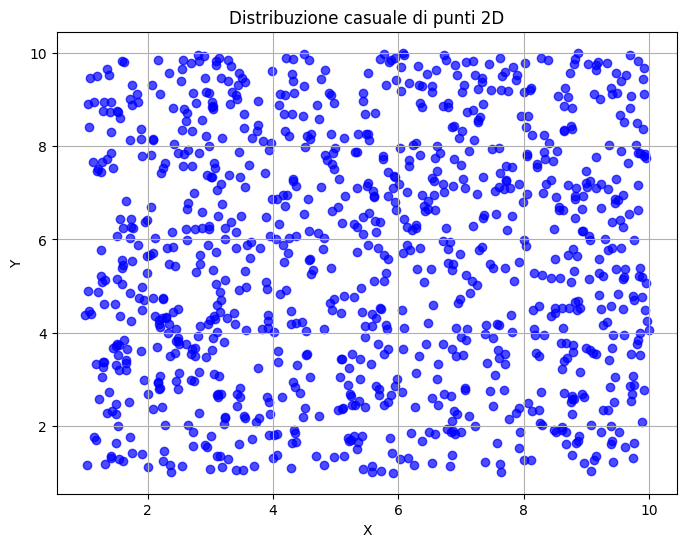

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], color='blue', alpha=0.7)
plt.title('Distribuzione casuale di punti 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


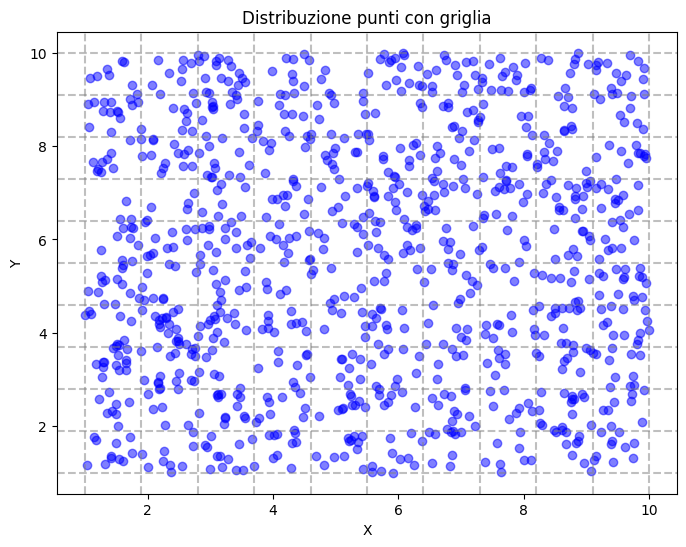

In [ ]:
n_bins = 10
x_edges = np.linspace(1, 10, n_bins+1)
y_edges = np.linspace(1, 10, n_bins+1)

# Calcolo istogramma 2D (ordine giusto -> [::-1] per y)
hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_edges, y_edges]) # points [: (tutte le righe), 0/1 (quale colonna)]
density = hist / ((x_edges[1]-x_edges[0])*(y_edges[1]-y_edges[0]))

# Visualizzazione delle cellette
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], color='blue', alpha=0.5)
for x in x_edges:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in y_edges:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
plt.title('Distribuzione punti con griglia')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


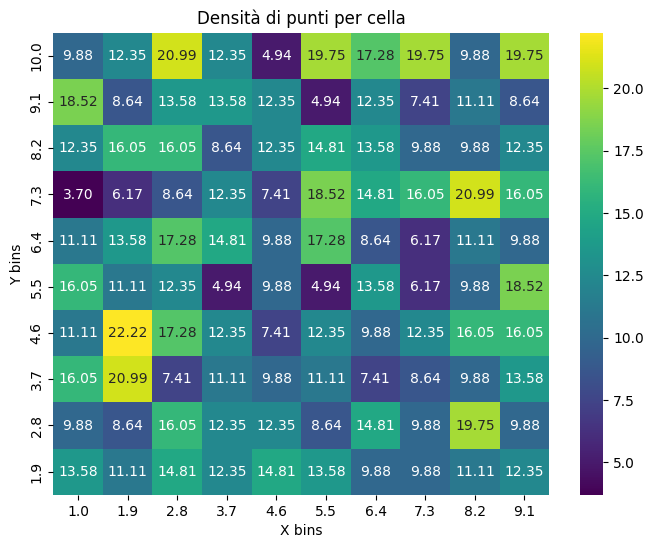

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(density.T[::-1], annot=True, fmt=".2f", cmap='viridis',
            xticklabels=np.round(x_edges[:-1], 1), yticklabels=np.round(y_edges[::-1][:-1], 1))
plt.title('Densità di punti per cella')
plt.xlabel('X bins')
plt.ylabel('Y bins')
plt.show()

In [ ]:
# Calcolo centri delle celle
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Creazione coordinate centri
xx, yy = np.meshgrid(x_centers, y_centers)
centers = np.column_stack([xx.ravel(), yy.ravel()])

# Matrice delle distanze euclidee
dist_matrix = np.sqrt(((centers[:, np.newaxis, :] - centers[np.newaxis, :, :])**2).sum(axis=2))

# Matrice dei pesi (1/d con d>0, 0 altrimenti)
weights_matrix = np.where(dist_matrix > 0, 1/dist_matrix, 0)


In [ ]:
# Rendo un array la densità per lavorare con array 1D
flat_density = density.T.ravel()  # Trasposta per allineare con l'ordine dei centri

# Calcolo media densità
mean_density = flat_density.mean()

# Calcolo numeratore e denominatore
n = len(flat_density)
S0 = weights_matrix.sum()

# Numeratore
numerator = 0
for i in range(n):
    for j in range(n):
        if i != j:
            numerator += weights_matrix[i,j] * (flat_density[i] - mean_density) * (flat_density[j] - mean_density)
numerator *= n

# Denominatore
denominator = S0 * ((flat_density - mean_density)**2).sum()

I_manual = numerator / denominator

# Calcolo valore atteso e varianza (sotto ipotesi di randomizzazione)
E_I = -1/(n-1)

# Varianza (formula semplificata)
S1 = (weights_matrix + weights_matrix.T).sum() / 2
S2 = ((weights_matrix.sum(axis=1) + weights_matrix.sum(axis=0))**2).sum()
n_sq = n*n
S0_sq = S0*S0

var_I = (n_sq*S1 - n*S2 + 3*S0_sq) / (S0_sq*(n_sq - 1)) - E_I**2

z_score = (I_manual-E_I)/np.sqrt(var_I)

p_values = normal_dist.sf(abs(z_score))


print("Risultati calcolo manuale:")
print(f"Indice di Moran: {I_manual:.4f}")
print(f"Valore atteso: {E_I:.4f}")
print(f"Varianza: {var_I:.4f}")
print(f"z = {z_score:.4f}")
print(f"p-value: {p_values:.4f}")

Risultati calcolo manuale:
Indice di Moran: -0.0146
Valore atteso: -0.0101
Varianza: 0.0001
z = -0.3852
p-value: 0.3501


In [ ]:
w = weights.DistanceBand.from_array(centers, threshold=np.inf, alpha=-1, binary=False)
w.transform = 'r'

moran = esda.Moran(flat_density, w)

print("\nRisultati pysal:")
print(f"Indice di Moran: {moran.I:.4f}")
print(f"Valore atteso: {moran.EI:.4f}")
print(f"Varianza: {moran.VI_rand:.4f}")
print(f"p-value: {moran.p_norm:.4f}")


Risultati pysal:
Indice di Moran: -0.0165
Valore atteso: -0.0101
Varianza: 0.0001
p-value: 0.5366


<Figure size 800x600 with 0 Axes>

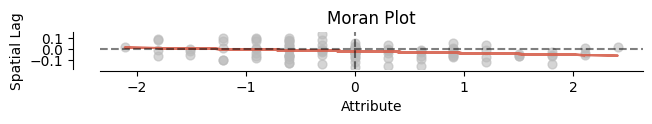

In [ ]:
# Moran plot semplice
plt.figure(figsize=(8,6))
moran_scatterplot(moran)
plt.title('Moran Plot')
plt.show()


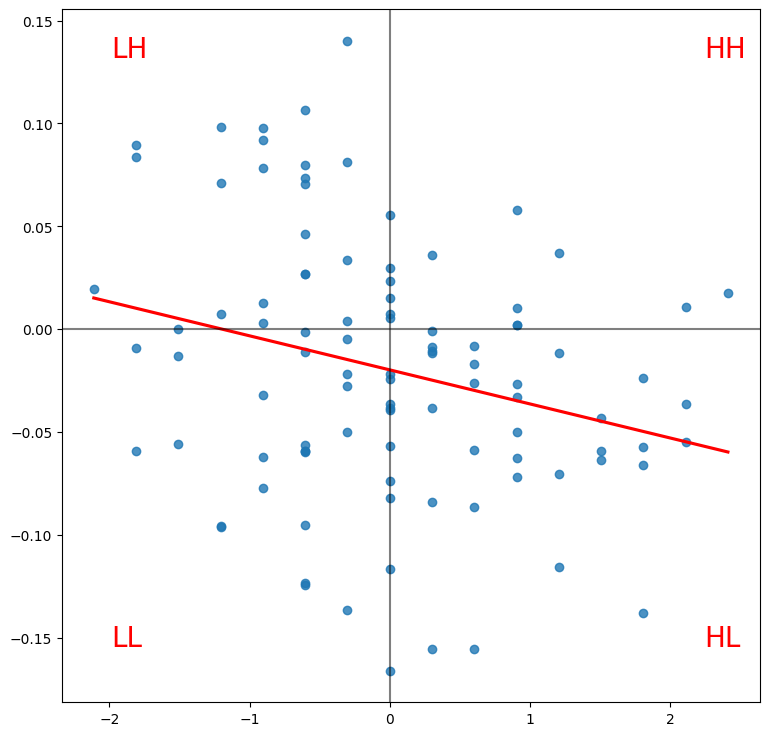

In [ ]:
z_density = (flat_density - flat_density.mean()) / flat_density.std()
wz = weights.lag_spatial(w, z_density)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=z_density, y=wz, ax=ax, ci=None, line_kws={'color':'red'})
# Add vertical and horizontal lines
# Add vertical and horizontal lines
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)

# Limiti reali del grafico
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Calcola posizioni relative
ax.text(xlim[1]*0.85, ylim[1]*0.85, "HH", fontsize=20, color='red')
ax.text(xlim[1]*0.85, ylim[0]*0.85, "HL", fontsize=20, color='red')
ax.text(xlim[0]*0.85, ylim[1]*0.85, "LH", fontsize=20, color='red')
ax.text(xlim[0]*0.85, ylim[0]*0.85, "LL", fontsize=20, color='red')

# Display
plt.show()

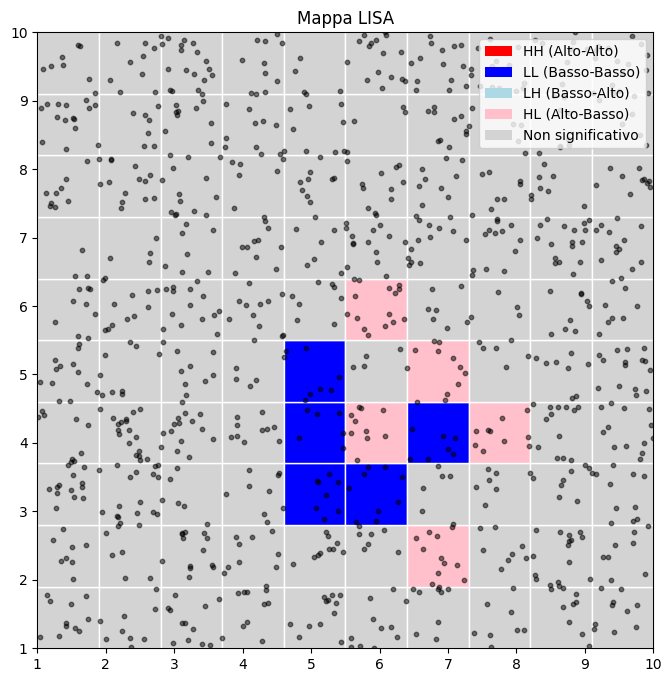

In [ ]:
lisa = Moran_Local(flat_density, w, permutations=999)

# Definisco la significatività
sig = lisa.p_sim < 0.05
cluster_labels = np.where(sig, lisa.q, 0)

# Mappa dei colori
fig, ax = plt.subplots(figsize=(10,8))
for (i,j), val in np.ndenumerate(density.T):
    idx = i*n_bins + j
    if cluster_labels[idx] == 1:  # HH
        color = 'red'
    elif cluster_labels[idx] == 2:  # LH
        color = 'lightblue'
    elif cluster_labels[idx] == 3:  # LL
        color = 'blue'
    elif cluster_labels[idx] == 4:  # HL
        color = 'pink'
    else:
        color = 'lightgray'

    rect = plt.Rectangle((x_edges[j], y_edges[i]),
                        x_edges[j+1]-x_edges[j],
                        y_edges[i+1]-y_edges[i],
                        facecolor=color, edgecolor='white')
    ax.add_patch(rect)

# Punti originali
ax.scatter(points[:,0], points[:,1], color='black', s=10, alpha=0.5)

# Legenda
legend_elements = [
    Patch(facecolor='red', label='HH (Alto-Alto)'),
    Patch(facecolor='blue', label='LL (Basso-Basso)'),
    Patch(facecolor='lightblue', label='LH (Basso-Alto)'),
    Patch(facecolor='pink', label='HL (Alto-Basso)'),
    Patch(facecolor='lightgray', label='Non significativo')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlim(1,10)
ax.set_ylim(1,10)
ax.set_aspect('equal')
plt.title('Mappa LISA')
plt.show()

# **Parte II**: *Moran Index per distribuzione casuale di punti con un cluster*


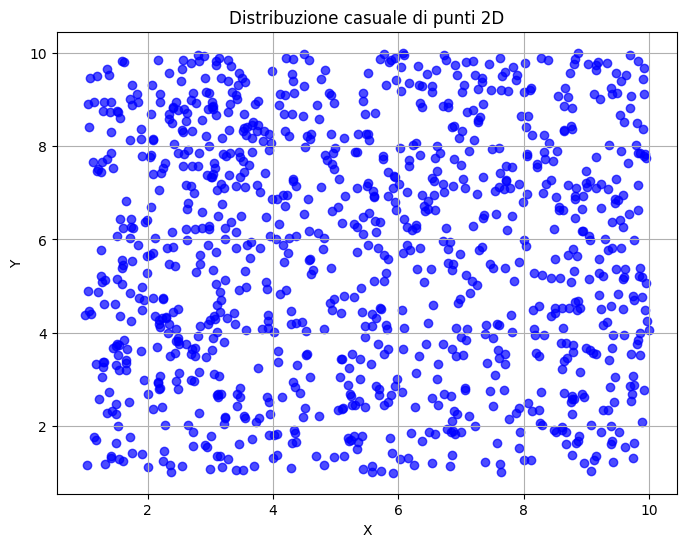

In [ ]:
np.random.seed(56)  # Per riproducibilità
n_points = 1000
points = np.random.uniform(low=1, high=10, size=(n_points, 2))

# Aggiunta del cluster
additional_points = np.random.uniform(low=[2,7], high=[4,9], size=(40, 2))

# Combiniamo con i punti originali
all_points = np.vstack([points, additional_points])

plt.figure(figsize=(8, 6))
plt.scatter(all_points[:, 0], all_points[:, 1], color='blue', alpha=0.7)
plt.title('Distribuzione casuale di punti 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

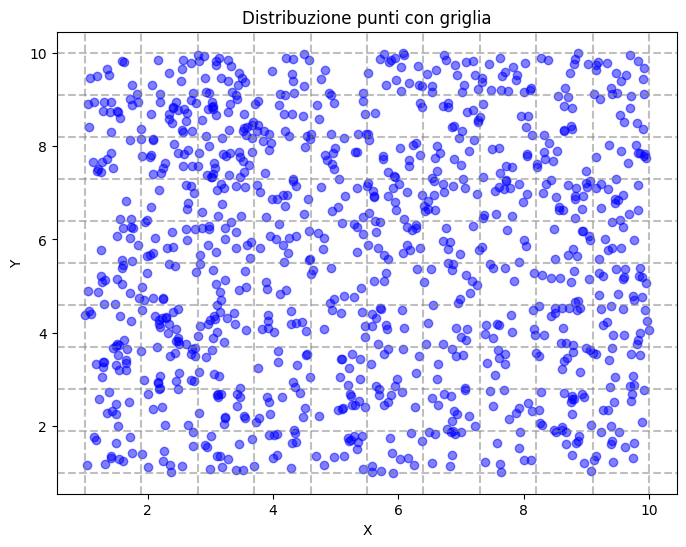

In [ ]:
n_bins = 10
x_edges = np.linspace(1, 10, n_bins+1)
y_edges = np.linspace(1, 10, n_bins+1)

# Calcolo istogramma 2D (ordine giusto -> [::-1] per y)
hist, xedges, yedges = np.histogram2d(all_points[:, 0], all_points[:, 1], bins=[x_edges, y_edges])
density = hist / ((x_edges[1]-x_edges[0])*(y_edges[1]-y_edges[0]))

# Visualizzazione delle cellette
plt.figure(figsize=(8, 6))
plt.scatter(all_points[:, 0], all_points[:, 1], color='blue', alpha=0.5)
for x in x_edges:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in y_edges:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
plt.title('Distribuzione punti con griglia')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

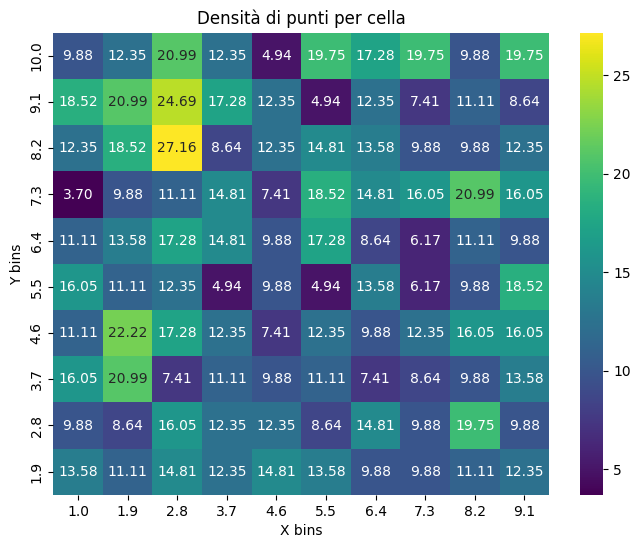

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(density.T[::-1], annot=True, fmt=".2f", cmap='viridis',
            xticklabels=np.round(x_edges[:-1], 1), yticklabels=np.round(y_edges[::-1][:-1], 1))
plt.title('Densità di punti per cella')
plt.xlabel('X bins')
plt.ylabel('Y bins')
plt.show()

In [ ]:
# Calcolo centri delle celle
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Creazione coordinate centri
xx, yy = np.meshgrid(x_centers, y_centers)
centers = np.column_stack([xx.ravel(), yy.ravel()])

# Matrice delle distanze euclidee
dist_matrix = np.sqrt(((centers[:, np.newaxis, :] - centers[np.newaxis, :, :])**2).sum(axis=2))

# Matrice dei pesi (1/d con d>0, 0 altrimenti)
weights_matrix = np.where(dist_matrix > 0, 1/dist_matrix, 0)

In [ ]:
# Rendo un array la densità per lavorare con array 1D
flat_density = density.T.ravel()  # Trasposta per allineare con l'ordine dei centri

# Calcolo media densità
mean_density = flat_density.mean()

# Calcolo numeratore e denominatore
n = len(flat_density)
S0 = weights_matrix.sum()

# Numeratore
numerator = 0
for i in range(n):
    for j in range(n):
        if i != j:
            numerator += weights_matrix[i,j] * (flat_density[i] - mean_density) * (flat_density[j] - mean_density)
numerator *= n

# Denominatore
denominator = S0 * ((flat_density - mean_density)**2).sum()

I_manual = numerator / denominator

# Calcolo valore atteso e varianza (sotto ipotesi di randomizzazione)
E_I = -1/(n-1)

# Varianza (formula semplificata)
S1 = (weights_matrix + weights_matrix.T).sum() / 2
S2 = ((weights_matrix.sum(axis=1) + weights_matrix.sum(axis=0))**2).sum()
n_sq = n*n
S0_sq = S0*S0

var_I = (n_sq*S1 - n*S2 + 3*S0_sq) / (S0_sq*(n_sq - 1)) - E_I**2


z_score = (I_manual-E_I)/np.sqrt(var_I)

p_values = normal_dist.sf(abs(z_score))

print("Risultati calcolo manuale:")
print(f"Indice di Moran: {I_manual:.4f}")
print(f"Valore atteso: {E_I:.4f}")
print(f"Varianza: {var_I:.4f}")
print(f"z = {z_score:.4f}")
print(f"p-value: {p_values:.4f}")

Risultati calcolo manuale:
Indice di Moran: 0.0104
Valore atteso: -0.0101
Varianza: 0.0001
z = 1.7582
p-value: 0.0394


In [ ]:
w = weights.DistanceBand.from_array(centers, threshold=np.inf, alpha=-1, binary=False)
w.transform = 'r'

moran = esda.Moran(flat_density, w)

print("\nRisultati pysal:")
print(f"Indice di Moran: {moran.I:.4f}")
print(f"Valore atteso: {moran.EI:.4f}")
print(f"Varianza: {moran.VI_rand:.4f}")
print(f"p-value: {moran.p_rand:.4f}")


Risultati pysal:
Indice di Moran: 0.0085
Valore atteso: -0.0101
Varianza: 0.0001
p-value: 0.0739


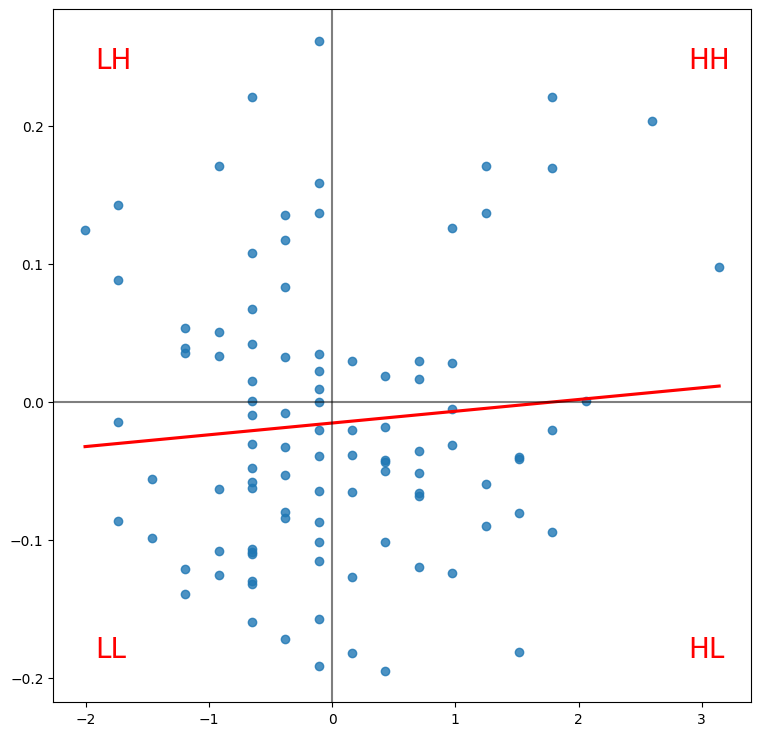

In [ ]:
z_density = (flat_density - flat_density.mean()) / flat_density.std()
wz = weights.lag_spatial(w, z_density)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=z_density, y=wz, ax=ax, ci=None, line_kws={'color':'red'})
# Add vertical and horizontal lines
# Add vertical and horizontal lines
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)

# Limiti reali del grafico
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Calcola posizioni relative
ax.text(xlim[1]*0.85, ylim[1]*0.85, "HH", fontsize=20, color='red')
ax.text(xlim[1]*0.85, ylim[0]*0.85, "HL", fontsize=20, color='red')
ax.text(xlim[0]*0.85, ylim[1]*0.85, "LH", fontsize=20, color='red')
ax.text(xlim[0]*0.85, ylim[0]*0.85, "LL", fontsize=20, color='red')

# Display
plt.show()

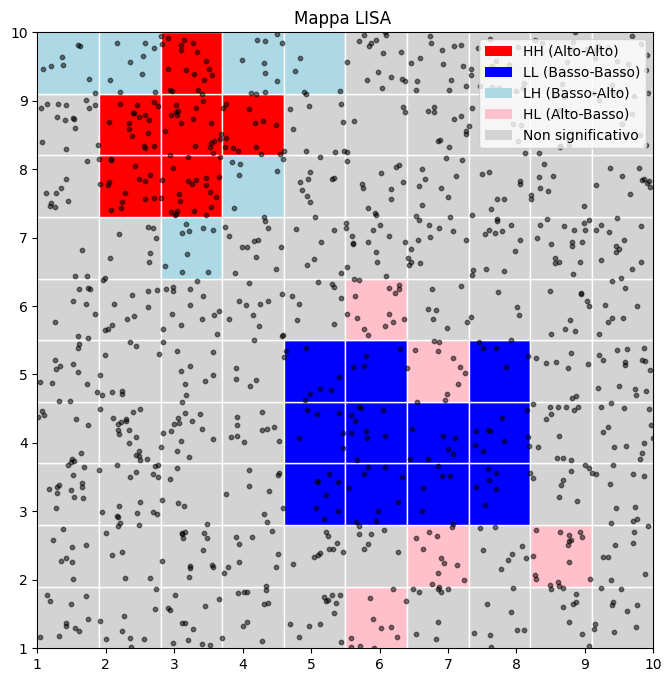

In [ ]:

lisa = Moran_Local(flat_density, w, permutations=999)

# Definisco la significatività
sig = lisa.p_sim < 0.05
cluster_labels = np.where(sig, lisa.q, 0)

# Mappa dei colori
fig, ax = plt.subplots(figsize=(10,8))
for (i,j), val in np.ndenumerate(density.T):
    idx = i*n_bins + j
    if cluster_labels[idx] == 1:  # HH
        color = 'red'
    elif cluster_labels[idx] == 2:  # LH
        color = 'lightblue'
    elif cluster_labels[idx] == 3:  # LL
        color = 'blue'
    elif cluster_labels[idx] == 4:  # HL
        color = 'pink'
    else:
        color = 'lightgray'

    rect = plt.Rectangle((x_edges[j], y_edges[i]),
                        x_edges[j+1]-x_edges[j],
                        y_edges[i+1]-y_edges[i],
                        facecolor=color, edgecolor='white')
    ax.add_patch(rect)

# Punti originali
ax.scatter(all_points[:,0], all_points[:,1], color='black', s=10, alpha=0.5)

# Legenda
legend_elements = [
    Patch(facecolor='red', label='HH (Alto-Alto)'),
    Patch(facecolor='blue', label='LL (Basso-Basso)'),
    Patch(facecolor='lightblue', label='LH (Basso-Alto)'),
    Patch(facecolor='pink', label='HL (Alto-Basso)'),
    Patch(facecolor='lightgray', label='Non significativo')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlim(1,10)
ax.set_ylim(1,10)
ax.set_aspect('equal')
plt.title('Mappa LISA ')
plt.show()

# **Parte III**: *Moran Index ma con pesi diversi*


In [ ]:
n_bins = 10
x_edges = np.linspace(1, 10, n_bins+1)
y_edges = np.linspace(1, 10, n_bins+1)

hist, _, _ = np.histogram2d(all_points[:,0], all_points[:,1], bins=[x_edges, y_edges])
density = hist / ((x_edges[1]-x_edges[0])*(y_edges[1]-y_edges[0]))

# Matrice dei pesi
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
xx, yy = np.meshgrid(x_centers, y_centers)
centers = np.column_stack([xx.ravel(), yy.ravel()])

# Con pesi a soglia (binary contiguity)
w = weights.DistanceBand.from_array(centers, threshold=1.5, binary=True)  # Soglia ottimizzata
w.transform = 'r'


In [ ]:
flat_density = density.T.ravel()
moran = Moran(flat_density, w)

print("Indice di Moran globale:")
print(f"I = {moran.I:.4f}")
print(f"Valore atteso E[I] = {moran.EI:.4f}")
print(f"p-value = {moran.p_norm:.4f}")


Indice di Moran globale:
I = 0.0693
Valore atteso E[I] = -0.0101
p-value = 0.1376


<Figure size 800x600 with 0 Axes>

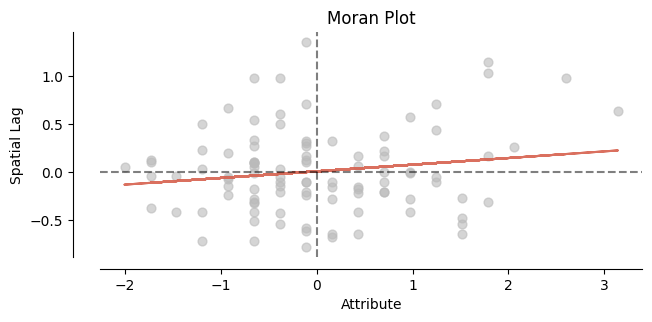

In [ ]:
plt.figure(figsize=(8,6))
moran_scatterplot(moran)
plt.title('Moran Plot')
plt.show()


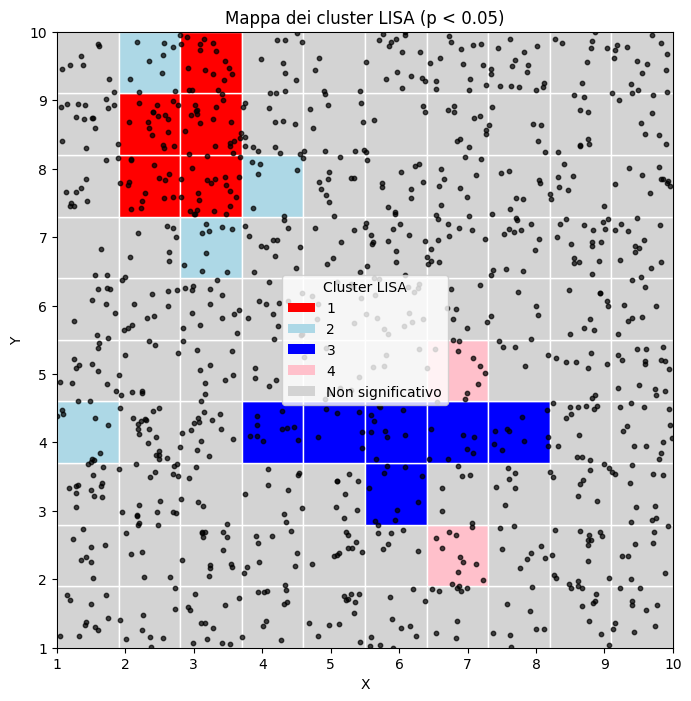


Statistiche cluster:
HH: 5 celle
LH: 4 celle
LL: 6 celle
HL: 2 celle
Non significative: 83 celle


In [ ]:
lisa = Moran_Local(flat_density, w, permutations=999)

# Colori
cluster_colors = {
    1: 'red',    # HH
    2: 'lightblue',   # LH
    3: 'blue', # LL
    4: 'pink',   # HL
    0: 'lightgray' # Non significativo
}

# Mappa dei cluster
sig = lisa.p_sim < 0.05
cluster_labels = np.where(sig, lisa.q, 0)

# Visualizzazione
fig, ax = plt.subplots(figsize=(10,8))
for (i,j), val in np.ndenumerate(density.T):
    color = cluster_colors[cluster_labels[i*n_bins + j]]
    rect = plt.Rectangle((x_edges[j], y_edges[i]),
                        x_edges[j+1]-x_edges[j],
                        y_edges[i+1]-y_edges[i],
                        facecolor=color, edgecolor='white')
    ax.add_patch(rect)

# Punti originali
ax.scatter(all_points[:,0], all_points[:,1], color='black', s=10, alpha=0.7)

# Legenda
legend_elements = [Patch(facecolor=v, label=k) for k,v in cluster_colors.items() if k != 0]
legend_elements.append(Patch(facecolor='lightgray', label='Non significativo'))
ax.legend(handles=legend_elements, title='Cluster LISA')

ax.set_xlim(1,10)
ax.set_ylim(1,10)
ax.set_aspect('equal')
plt.title('Mappa dei cluster LISA (p < 0.05)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Statistiche cluster
print("\nStatistiche cluster:")
print(f"HH: {(cluster_labels == 1).sum()} celle")
print(f"LH: {(cluster_labels == 2).sum()} celle")
print(f"LL: {(cluster_labels == 3).sum()} celle")
print(f"HL: {(cluster_labels == 4).sum()} celle")
print(f"Non significative: {(cluster_labels == 0).sum()} celle")

# **Parte IV**: *Moran Index con campo reale*


In [3]:
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
! pip install adjustText
from adjustText import adjust_text
from scipy.spatial import cKDTree

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.io import fits

# Percorso esatto al tuo file su Drive
path = "/content/drive/MyDrive/environment_redsequence/J082729_73/galaxiesSDSS.fits"
hdul = fits.open(path)
hdul.info()

Mounted at /content/drive
Filename: /content/drive/MyDrive/environment_redsequence/J082729_73/galaxiesSDSS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (2234,)   uint8   
  1  /Users/lorenzotagliapietra/Documents/Universita/Tesi_Magistrale/envi    1 BinTableHDU     90   821R x 39C   [23A, E, D, D, D, D, D, D, 19A, D, D, E, E, I, E, E, I, E, E, I, E, E, I, E, E, I, I, E, E, D, D, E, E, E, E, D, D, D, D]   


In [54]:
#apro i dati
data = hdul[1].data
ra = data['RAJ2000'].astype(np.float32)
dec = data['DEJ2000'].astype(np.float32)
ang_sep = data['angsep']
r_mag = data['rmag']
xs = data['xs']
ys = data['ys']
#r_mag = data['rPSFMag']

for i in range(32, 47):
    val = i / 2.
    mask = r_mag > val
    data_filtered = data[mask]

    globals()[f"mask_{val}"] = mask
    globals()[f"data_{val}"] = data_filtered
    globals()[f"ra_{val}"] = data_filtered['RAJ2000']
    globals()[f"dec_{val}"] = data_filtered['DEJ2000']
    globals()[f"ang_sep_{val}"] = data_filtered['angsep']
    globals()[f"xs_{val}"] = data_filtered['xs']
    globals()[f"ys_{val}"] = data_filtered['ys']

    print(f"Data > {val}: {len(data_filtered)} oggetti")
    print(f"ra_{val} = {ra[:5]}")
    print(f"dec_{val} = {dec[:5]}")
    print(f"ang_sep_{val} = {ang_sep[:5]}")

target_idx = np.argmin(ang_sep)
print(f"L'oggetto è a {ra[target_idx]},{dec[target_idx]},{ang_sep[target_idx]}")

print(f" Total data {len(ra)}")

Data > 16.0: 820 oggetti
ra_16.0 = [126.45152  126.455925 126.45956  126.46064  126.46078 ]
dec_16.0 = [53.121277 53.101315 53.13631  53.103493 53.155415]
ang_sep_16.0 = [912.56942779 907.46559376 895.68612624 896.56328171 898.35490085]
Data > 16.5: 819 oggetti
ra_16.5 = [126.45152  126.455925 126.45956  126.46064  126.46078 ]
dec_16.5 = [53.121277 53.101315 53.13631  53.103493 53.155415]
ang_sep_16.5 = [912.56942779 907.46559376 895.68612624 896.56328171 898.35490085]
Data > 17.0: 815 oggetti
ra_17.0 = [126.45152  126.455925 126.45956  126.46064  126.46078 ]
dec_17.0 = [53.121277 53.101315 53.13631  53.103493 53.155415]
ang_sep_17.0 = [912.56942779 907.46559376 895.68612624 896.56328171 898.35490085]
Data > 17.5: 806 oggetti
ra_17.5 = [126.45152  126.455925 126.45956  126.46064  126.46078 ]
dec_17.5 = [53.121277 53.101315 53.13631  53.103493 53.155415]
ang_sep_17.5 = [912.56942779 907.46559376 895.68612624 896.56328171 898.35490085]
Data > 18.0: 790 oggetti
ra_18.0 = [126.45152  126.4

In [55]:
#Trasformazione in coordinate gnomoniche

# Centro della proiezione
ra_center = ra[target_idx]
dec_center = dec[target_idx]

# Crea un oggetto SkyCoord
coords = SkyCoord(ra=ra, dec=dec, unit="deg", frame="icrs")

coords_object = SkyCoord(ra=ra[target_idx], dec=dec[target_idx], unit="deg", frame="icrs")

center = SkyCoord(ra=ra_center, dec=dec_center, unit="deg", frame="icrs")

# Crea un sistema di coordinate gnomoniche (WCS)
wcs = WCS(naxis=2)
wcs.wcs.crval = [ra_center, dec_center]  # centro proiezione
wcs.wcs.crpix = [0, 0]                   # origine messa in (0,0)
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"] # proiezione gnomonica
wcs.wcs.cdelt = np.array([-0.000381944444, 0.000381944444])  # 1 arcsec per pixel (opzionale)

x, y = skycoord_to_pixel(coords, wcs)
x_object, y_object = skycoord_to_pixel(coords_object, wcs)

print(f"coordinate in wcs ra = {ra[:5]}")
print(f"coordinate in wcs dec = {dec[:5]}")
print(f"coordinate in pixel x = {x[:5]}")
print(f"coordinate in pixel y = {y[:5]}")


coordinate in wcs ra = [126.45152  126.455925 126.45956  126.46064  126.46078 ]
coordinate in wcs dec = [53.121277 53.101315 53.13631  53.103493 53.155415]
coordinate in pixel x = [653.58044572 646.96440536 640.73300318 639.5202005  638.53119551]
coordinate in pixel y = [ -8.39483342 -60.69943538  30.8931942  -55.03896984  80.89968047]


In [23]:
import pandas as pd
from esda.moran import Moran, Moran_Local
from libpysal.weights import lat2W

def test_cell_sizes(data, min_points=5, stability_thresh=0.05, min_steps=3,
                    permutations=999):
    """
    data: DataFrame con colonne 'x','y' (coordinate già proiettate, es. Mpc o gradi)
    Ritorna:
      res  -> tabella con metriche per ogni dimensione di cella
      best -> riga selezionata come dimensione 'ottimale'
      lisa_dict -> dizionario {cell_size: (Ii, pvals)} per analisi LISA
    """
    results = []
    lisa_dict = {}

    # dimensione campo
    field_size = max(data['xs'].max()-data['xs'].min(),
                     data['ys'].max()-data['ys'].min())

    # scala iniziale -> dividi a metà fino a 7 step (~1/128 del campo)
    cell_sizes = field_size / (2 ** np.arange(1,8))

    for cs in cell_sizes:
        x_bins = np.arange(data['xs'].min(), data['xs'].max()+cs, cs)
        y_bins = np.arange(data['ys'].min(), data['ys'].max()+cs, cs)
        H, _, _ = np.histogram2d(data['xs'], data['ys'],
                                 bins=[x_bins, y_bins])
        dens = H.flatten()
        nx, ny = H.shape

        # scarta se troppe celle vuote
        non_empty_frac = (dens>0).mean()
        if non_empty_frac < 0.7:   # almeno 70% celle popolate
            continue

        # pesi queen contiguità
        w = lat2W(nx, ny, rook=False)

        # Moran globale
        mi = Moran(dens, w, permutations=permutations)

        # Moran locale
        lisa = Moran_Local(dens, w, permutations=permutations)
        lisa_dict[cs] = (lisa.Is, lisa.p_sim)

        results.append({
            'cell_size': cs,
            'moran_I': mi.I,
            'p_value': mi.p_sim,
            'mean_density': dens.mean(),
            'var_density': dens.var(),
            'non_empty_frac': non_empty_frac
        })

    res = pd.DataFrame(results).sort_values('cell_size', ascending=False)
    res['delta_I'] = res['moran_I'].diff().abs()/res['moran_I'].shift()

    # criterio di stabilizzazione
    stable = res[res['delta_I'] < stability_thresh]
    if len(stable) >= min_steps:
        best_idx = stable.index[min_steps-1]
    else:
        sig = res[res['p_value']<0.05]
        best_idx = sig['moran_I'].idxmax() if len(sig)>0 else res['moran_I'].idxmax()

    return res, res.loc[best_idx], lisa_dict


In [56]:
# Esegui analisi multiscala
res, best, lisa_dict = test_cell_sizes(data, permutations=999)

print("Dimensione ottimale (deg o Mpc):", best['cell_size'])
display(res)   # tabella completa

field_size = max(data['xs'].max()-data['xs'].min(),
                     data['ys'].max()-data['ys'].min())
n_bins = int(np.ceil(field_size / best['cell_size']))
print(f"Suggested cell size ≈ {best['cell_size']:.4f}, suggested n_bins ≈ {n_bins}")


Dimensione ottimale (deg o Mpc): 0.03173067051369388


,cell_size,moran_I,p_value,mean_density,var_density,non_empty_frac,delta_I
0,0.253845,-0.333333,0.499,205.250000,527.687500,1.000000,NaN
1,0.126923,-0.054955,0.455,51.312500,443.589844,1.000000,-0.835135
2,0.063461,0.359993,0.001,12.828125,52.829834,0.937500,-7.550681
3,0.031731,0.351519,0.001,3.207031,6.164169,0.816406,0.023540


Suggested cell size ≈ 0.0317, suggested n_bins ≈ 16


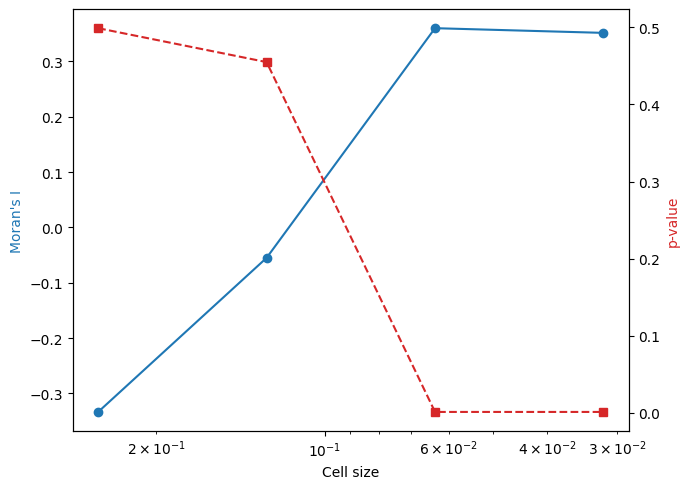

In [57]:
fig, ax1 = plt.subplots(figsize=(7,5))
ax2 = ax1.twinx()

ax1.plot(res['cell_size'], res['moran_I'], 'o-', color='tab:blue', label="Moran's I")
ax2.plot(res['cell_size'], res['p_value'], 's--', color='tab:red', label='p-value')

ax1.set_xscale('log')
ax1.set_xlabel('Cell size')
ax1.set_ylabel("Moran's I", color='tab:blue')
ax2.set_ylabel('p-value', color='tab:red')
ax1.invert_xaxis()  # cella più piccola a destra

fig.tight_layout()
plt.show()


/tmp/ipython-input-4277492073.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


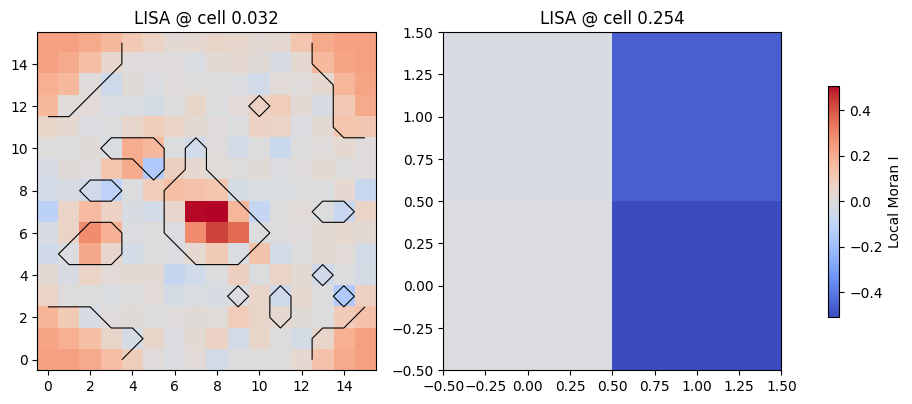

In [58]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# esempio: confronta la scala migliore con una più grossolana
scales_to_plot = [best['cell_size'], res['cell_size'].iloc[0]]  # ottimale vs massima
fig, axs = plt.subplots(1, len(scales_to_plot), figsize=(6*len(scales_to_plot),5))

for ax, cs in zip(np.atleast_1d(axs), scales_to_plot):
    Ii, pvals = lisa_dict[cs]
    # significance mask (p<0.05)
    sig = pvals < 0.05

    nx = ny = int(np.sqrt(len(Ii)))
    Ii_grid = Ii.reshape(nx, ny)
    sig_grid = sig.reshape(nx, ny)

    cmap = cm.get_cmap('coolwarm')
    im = ax.imshow(Ii_grid, cmap=cmap, origin='lower',
                   norm=Normalize(vmin=-np.max(np.abs(Ii)), vmax=np.max(np.abs(Ii))))
    ax.set_title(f"LISA @ cell {cs:.3f}")
    # bordo per celle significative
    ax.contour(sig_grid, levels=[0.5], colors='k', linewidths=0.8)

fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, label='Local Moran I')
plt.show()


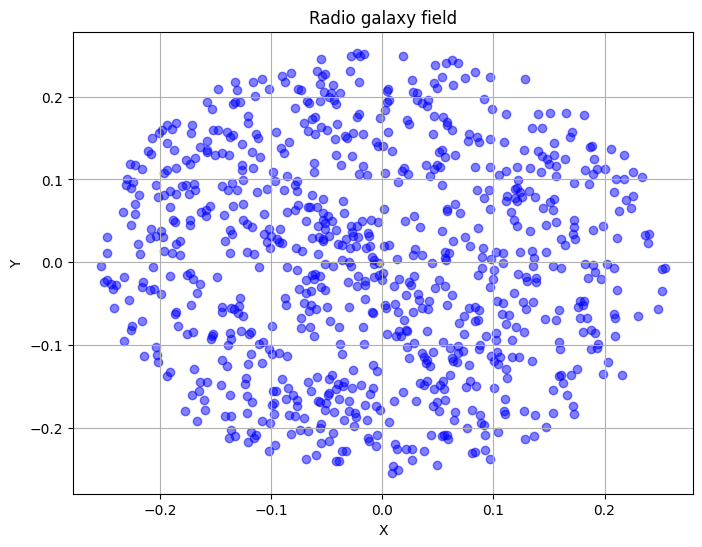

In [68]:


objects = np.column_stack((xs, ys))
xs_object = xs[target_idx]
ys_object = ys[target_idx]

plt.figure(figsize=(8, 6))
plt.scatter(objects[:, 0], objects[:, 1], color='blue', alpha=0.5)
plt.scatter(xs_object, ys_object, color='gold', s=10, alpha=0.5)
plt.title('Radio galaxy field')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


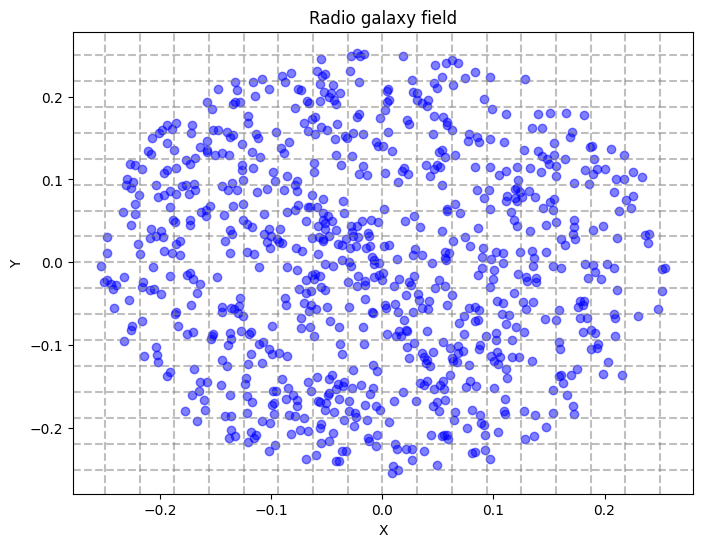

In [69]:
x_edges = np.linspace(-0.25,0.25, n_bins+1)
y_edges = np.linspace(-0.25, 0.25, n_bins+1)

# Calcolo istogramma 2D (ordine giusto -> [::-1] per y)
hist, xedges, yedges = np.histogram2d(objects[:, 0], objects[:, 1], bins=[x_edges, y_edges])
density = hist / ((x_edges[1]-x_edges[0])*(y_edges[1]-y_edges[0]))

# Visualizzazione delle cellette
plt.figure(figsize=(8, 6))
plt.scatter(objects[:, 0], objects[:, 1], color='blue', alpha=0.5)
for x in x_edges:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in y_edges:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)
plt.title('Radio galaxy field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

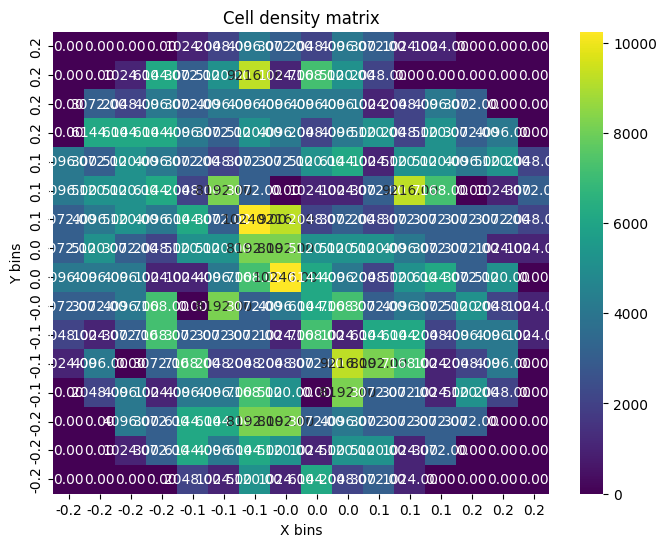

In [70]:
plt.figure(figsize=(8, 6))
sns.heatmap(density.T[::-1], annot=True, fmt=".2f", cmap='viridis',
            xticklabels=np.round(x_edges[:-1], 1), yticklabels=np.round(y_edges[::-1][:-1], 1))
plt.title('Cell density matrix')
plt.xlabel('X bins')
plt.ylabel('Y bins')
plt.show() #qui non mettere i numeri sugli assi solo la sidemap dei colori

In [71]:
# Calcolo centri delle celle
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Creazione coordinate centri
xx, yy = np.meshgrid(x_centers, y_centers)
centers = np.column_stack([xx.ravel(), yy.ravel()])

# Rendo un array la densità per lavorare con array 1D
flat_density = density.T.ravel()  # Trasposta per allineare con l'ordine dei centri

# Calcolo media densità
mean_density = flat_density.mean()



In [72]:
w = weights.DistanceBand.from_array(centers, threshold=np.inf, alpha=-1, binary=False)
w.transform = 'r'

moran = esda.Moran(flat_density, w)

print("\nRisultati pysal:")
print(f"Indice di Moran: {moran.I:.4f}")
print(f"Valore atteso: {moran.EI:.4f}")
print(f"Varianza: {moran.VI_rand:.4f}")
print(f"p-value: {moran.p_rand:e}")


Risultati pysal:
Indice di Moran: 0.0639
Valore atteso: -0.0039
Varianza: 0.0000
p-value: 3.761427e-44


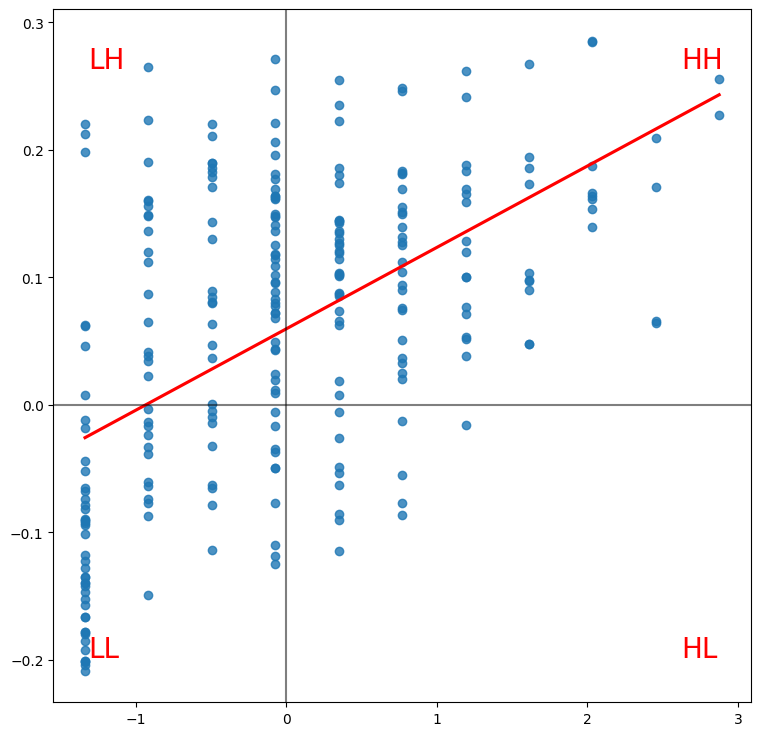

In [73]:
z_density = (flat_density - flat_density.mean()) / flat_density.std()
wz = weights.lag_spatial(w, z_density)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=z_density, y=wz, ax=ax, ci=None, line_kws={'color':'red'})
# Add vertical and horizontal lines
# Add vertical and horizontal lines
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)

# Limiti reali del grafico
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Calcola posizioni relative
ax.text(xlim[1]*0.85, ylim[1]*0.85, "HH", fontsize=20, color='red')
ax.text(xlim[1]*0.85, ylim[0]*0.85, "HL", fontsize=20, color='red')
ax.text(xlim[0]*0.85, ylim[1]*0.85, "LH", fontsize=20, color='red')
ax.text(xlim[0]*0.85, ylim[0]*0.85, "LL", fontsize=20, color='red')

# Display
plt.show()

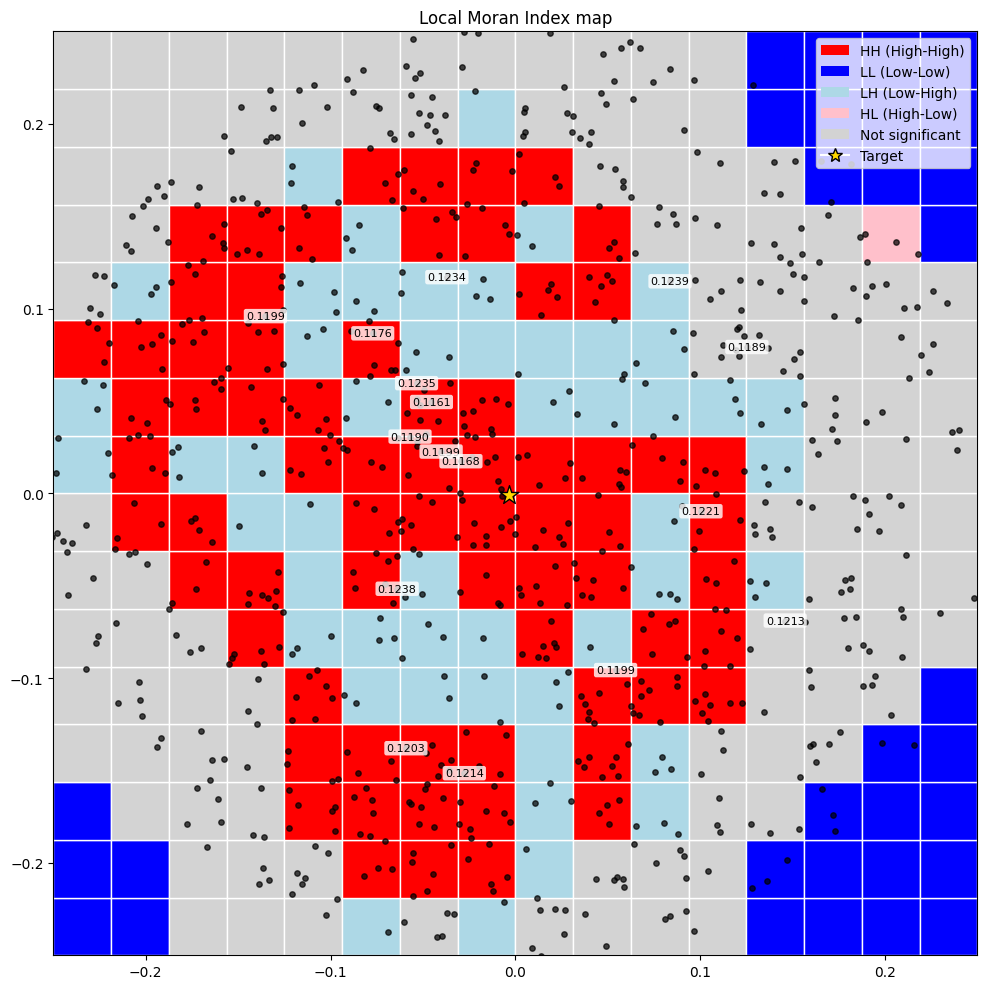

In [74]:
# Calcolo LISA
lisa = Moran_Local(flat_density, w, permutations=999)

# Definisco la significatività
sig = lisa.p_sim < 0.05
cluster_labels = np.where(sig, lisa.q, 0)

# Mappa dei colori
fig, ax = plt.subplots(figsize=(12,10))

# Prima disegna le celle LISA
for (i,j), val in np.ndenumerate(density.T):
    idx = i*n_bins + j
    if cluster_labels[idx] == 1:  # HH
        color = 'red'
    elif cluster_labels[idx] == 2:  # LH
        color = 'lightblue'
    elif cluster_labels[idx] == 3:  # LL
        color = 'blue'
    elif cluster_labels[idx] == 4:  # HL
        color = 'pink'
    else:
        color = 'lightgray'

    rect = plt.Rectangle((x_edges[j], y_edges[i]),
                        x_edges[j+1]-x_edges[j],
                        y_edges[i+1]-y_edges[i],
                        facecolor=color, edgecolor='white')
    ax.add_patch(rect)

# Estrai i valori zsp (gestendo i valori blank)
zsp_values = []
for val in data['zsp']:
    try:
        zsp_values.append(float(val))
    except (ValueError, TypeError):
        zsp_values.append(np.nan)
zsp_values = np.array(zsp_values)

# Preparazione delle etichette per zsp
texts = []
plotted_points = []

target_star = ax.scatter(xs_object, ys_object, color='gold', s=200, marker='*',
                        edgecolor='black', linewidth=1, zorder=10)

# Disegna prima tutti i punti neri
scatter = ax.scatter(objects[:,0], objects[:,1], color='black', s=15, alpha=0.7)

# Poi aggiungi le etichette solo per i punti con zsp valido
for i in range(len(objects)):
    x, y = objects[i, 0], objects[i, 1]

    # Mostra etichetta solo per zsp validi e sopra una certa soglia
    if not np.isnan(zsp_values[i]) and zsp_values[i] > 0.00:
        t = ax.text(x, y, f"{zsp_values[i]:.4f}",
                   fontsize=8, color='black',
                   ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.2',
                           facecolor='white',
                           alpha=0.8,
                           edgecolor='none'))
        texts.append(t)
        plotted_points.append((x,y))
try:
    from adjust_text import adjust_text
    adjust_text(texts,
               x=[p[0] for p in plotted_points],
               y=[p[1] for p in plotted_points],
               arrowprops=dict(arrowstyle='-', color='lighgrey', lw=0.3))
except ImportError:
    pass

# Legenda migliorata
legend_elements = [
    Patch(facecolor='red', label='HH (High-High)'),
    Patch(facecolor='blue', label='LL (Low-Low)'),
    Patch(facecolor='lightblue', label='LH (Low-High)'),
    Patch(facecolor='pink', label='HL (High-Low)'),
    Patch(facecolor='lightgray', label='Not significant'),
    plt.Line2D([0], [0], marker='*', color='w', label='Target',
              markerfacecolor='gold', markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlim(-0.25,0.25)
ax.set_ylim(-0.25,0.25)
ax.set_aspect('equal')
plt.title('Local Moran Index map')
plt.tight_layout()
plt.show()

# Uso i tagli in magnitudine

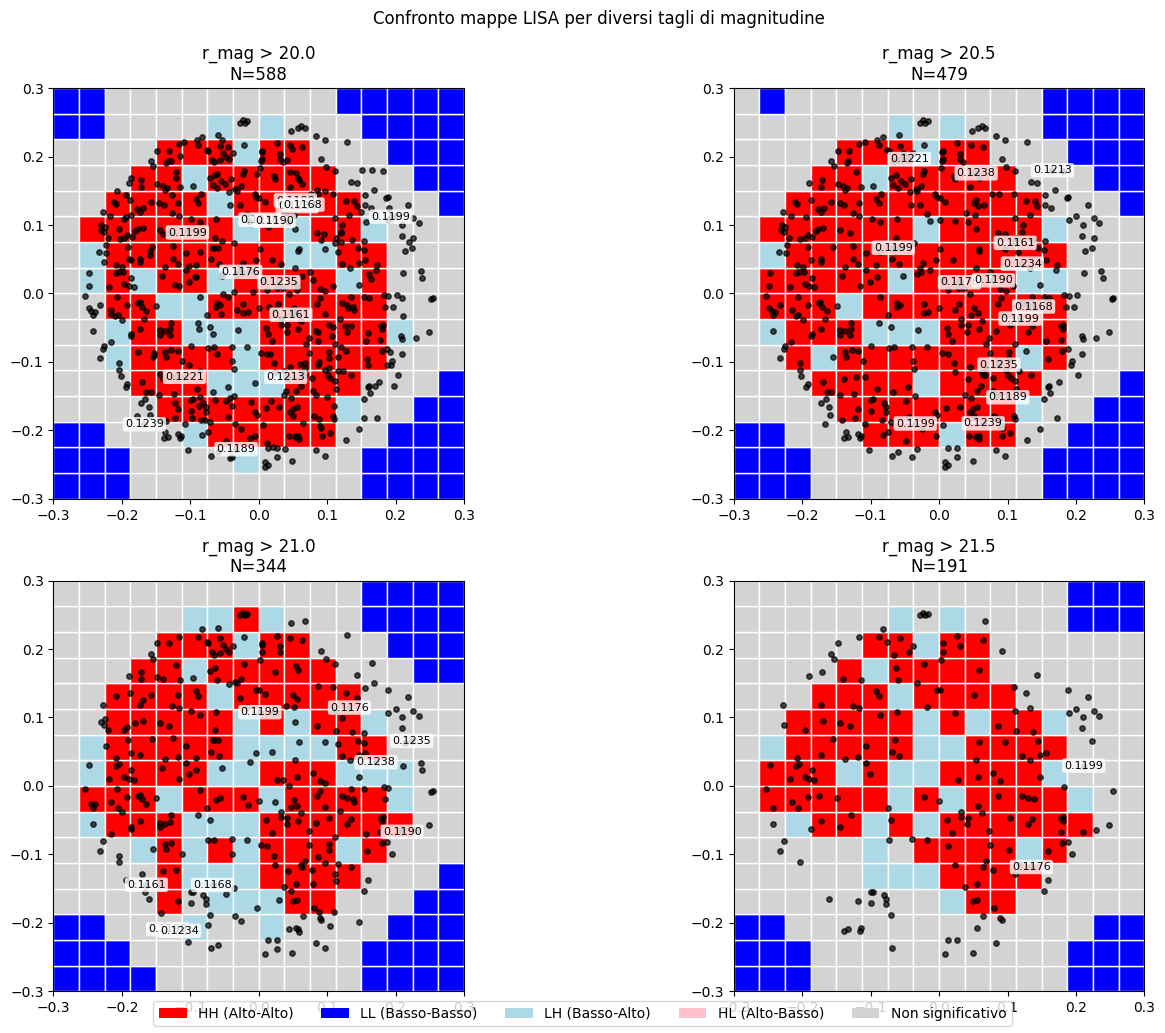

In [75]:
magnitude_cuts = [20.0, 20.5, 21.0, 21.5]  # Esempio con 3 tagli

# Crea una figura con subplot
n_rows = int(np.ceil(len(magnitude_cuts)**0.5))
n_cols = int(np.ceil(len(magnitude_cuts) / n_rows))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
if len(magnitude_cuts) == 1:
    axes = np.array([axes])
axes = axes.flatten()

# Parametri comuni
n_bins = 16
x_edges = np.linspace(-0.3, 0.3, n_bins+1)
y_edges = np.linspace(-0.3, 0.3, n_bins+1)

# Peso spaziale
w = weights.DistanceBand.from_array(centers, threshold=np.inf, alpha=-1, binary=False)
w.transform = 'r'

# Loop su ogni taglio di magnitudine
for idx, mag_cut in enumerate(magnitude_cuts):
    ax = axes[idx]

    # Estrai i dati filtrati
    data_filtered = globals()[f"data_{mag_cut}"]

    # Converti coordinate in pixel
    ra_filtered = data_filtered['xs'].astype(np.float32)
    dec_filtered = data_filtered['ys'].astype(np.float32)
    objects_filtered = np.column_stack([ra_filtered, dec_filtered])

    # Calcolo istogramma 2D
    hist, _, _ = np.histogram2d(objects_filtered[:, 0], objects_filtered[:, 1], bins=[x_edges, y_edges])
    density = hist / ((x_edges[1]-x_edges[0])*(y_edges[1]-y_edges[0]))
    flat_density = density.T.ravel()

    # Calcolo LISA
    lisa = Moran_Local(flat_density, w, permutations=999)
    sig = lisa.p_sim < 0.05
    cluster_labels = np.where(sig, lisa.q, 0)

    # Disegna le celle colorate
    for (i,j), val in np.ndenumerate(density.T):
        cell_idx = i*n_bins + j
        if cluster_labels[cell_idx] == 1:  # HH
            color = 'red'
        elif cluster_labels[cell_idx] == 2:  # LH
            color = 'lightblue'
        elif cluster_labels[cell_idx] == 3:  # LL
            color = 'blue'
        elif cluster_labels[cell_idx] == 4:  # HL
            color = 'pink'
        else:
            color = 'lightgray'

        rect = plt.Rectangle((x_edges[j], y_edges[i]),
                            x_edges[j+1]-x_edges[j],
                            y_edges[i+1]-y_edges[i],
                            facecolor=color, edgecolor='white')
        ax.add_patch(rect)

     # Estrai i valori zsp (gestendo i valori blank)
    zsp_values = []
    for val in data['zsp']:
      try:
        zsp_values.append(float(val))
      except (ValueError, TypeError):
        zsp_values.append(np.nan)
    zsp_values = np.array(zsp_values)

    # Preparazione delle etichette per zsp
    texts = []
    plotted_points = []

    # Disegna prima tutti i punti neri
    scatter = ax.scatter(objects_filtered[:,0], objects_filtered[:,1], color='black', s=15, alpha=0.7)

    # Poi aggiungi le etichette solo per i punti con zsp valido
    for i in range(len(objects_filtered)):
      x, y = objects_filtered[i, 0], objects_filtered[i, 1]

      # Mostra etichetta solo per zsp validi e sopra una certa soglia
      if not np.isnan(zsp_values[i]) and zsp_values[i] > 0.00:
          t = ax.text(x, y, f"{zsp_values[i]:.4f}",
                    fontsize=8, color='black',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.2',
                            facecolor='white',
                             alpha=0.8,
                            edgecolor='none'))
          texts.append(t)
          plotted_points.append((x,y))
    try:
      from adjust_text import adjust_text
      adjust_text(texts,
                x=[p[0] for p in plotted_points],
                y=[p[1] for p in plotted_points],
                arrowprops=dict(arrowstyle='-', color='black', lw=0.3))
    except ImportError:
     pass

    # Titolo e formattazione
    ax.set_title(f'r_mag > {mag_cut}\nN={len(objects_filtered)}')
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.3,0.3)
    ax.set_aspect('equal')

# Aggiungi legenda comune
legend_elements = [
    Patch(facecolor='red', label='HH (Alto-Alto)'),
    Patch(facecolor='blue', label='LL (Basso-Basso)'),
    Patch(facecolor='lightblue', label='LH (Basso-Alto)'),
    Patch(facecolor='pink', label='HL (Alto-Basso)'),
    Patch(facecolor='lightgray', label='Non significativo')
]

# Posiziona la legenda in un subplot vuoto se necessario
if len(magnitude_cuts) < len(axes):
    axes[len(magnitude_cuts)].legend(handles=legend_elements, loc='center')
    axes[len(magnitude_cuts)].axis('off')
else:
    # Altrimenti metti la leganda fuori dalla figura
    fig.legend(handles=legend_elements, loc='lower center', ncol=5)

plt.tight_layout()
plt.suptitle('Confronto mappe LISA per diversi tagli di magnitudine', y=1.02)
plt.show()